In [2]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

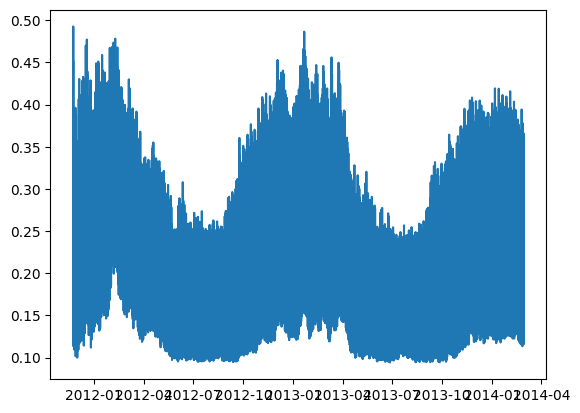

In [6]:
# Load the data
df = pd.read_csv('processed_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

df

#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

In [10]:
#check for break in timestamps
import pandas as pd

# Assuming df is your DataFrame and 'timestamp' is your timestamp column
df = df.sort_values('DateTime')

# Calculate the difference between current and previous timestamp
df['time_diff'] = df['DateTime'].diff()

# Define a threshold for a break, e.g., 1 hour
threshold = pd.Timedelta(hours=1)

# Check if there are any breaks
has_breaks = any(df['time_diff'] > threshold)

print(f"Data has breaks: {has_breaks}")

Data has breaks: False


In [85]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
print(next(stream))

({'DateTime': Timestamp('2011-11-23 09:00:00'), 'day_of_week': 2, 'hour_of_day': 9, 'month': 11, 'time_diff': NaT}, 0.355)


{}
0.0
LinearRegression
{'MAE': MAE: 0.414, 'Step': 1, 'Prediction': 0.0}
{'MAE': MAE: 0.29425, 'Step': 2, 'Prediction': 0.0}
{'MAE': MAE: 0.234083, 'Step': 3, 'Prediction': 0.0}
{'MAE': MAE: 0.209063, 'Step': 4, 'Prediction': 0.0}
{'MAE': MAE: 0.20917, 'Step': 5, 'Prediction': 0.0}
{'MAE': MAE: 0.249618, 'Step': 6, 'Prediction': 0.0}
{'MAE': MAE: 0.26353, 'Step': 7, 'Prediction': 0.0}
{'MAE': MAE: 0.266588, 'Step': 8, 'Prediction': 0.0}
{'MAE': MAE: 0.265089, 'Step': 9, 'Prediction': 0.0}
{'MAE': MAE: 0.268498, 'Step': 10, 'Prediction': 0.0}
{'MAE': MAE: 0.26423, 'Step': 11, 'Prediction': 0.0}
{'MAE': MAE: 0.260877, 'Step': 12, 'Prediction': 0.0}
{'MAE': MAE: 0.253908, 'Step': 13, 'Prediction': 0.0}
{'MAE': MAE: 0.246745, 'Step': 14, 'Prediction': 0.0}
{'MAE': MAE: 0.24655, 'Step': 15, 'Prediction': 0.0}
{'MAE': MAE: 0.247181, 'Step': 16, 'Prediction': 0.0}
{'MAE': MAE: 0.247523, 'Step': 17, 'Prediction': 0.0}
{'MAE': MAE: 0.249408, 'Step': 18, 'Prediction': 0.0}
{'MAE': MAE: 0.251382

C:\Users\Stijn\AppData\Local\Temp\ipykernel_36064\2164301897.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_36064\2164301897.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')


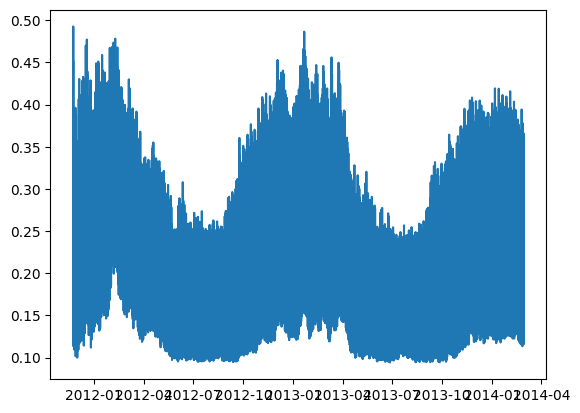

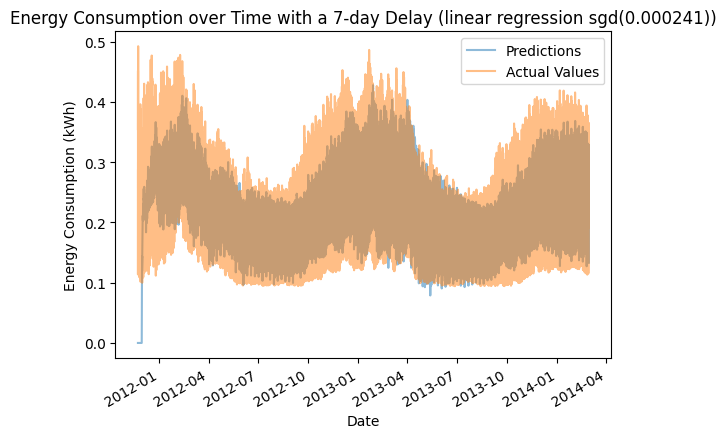

C:\Users\Stijn\AppData\Local\Temp\ipykernel_36064\2164301897.py:97: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_36064\2164301897.py:100: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, alpha=0.5, label='Predictions')


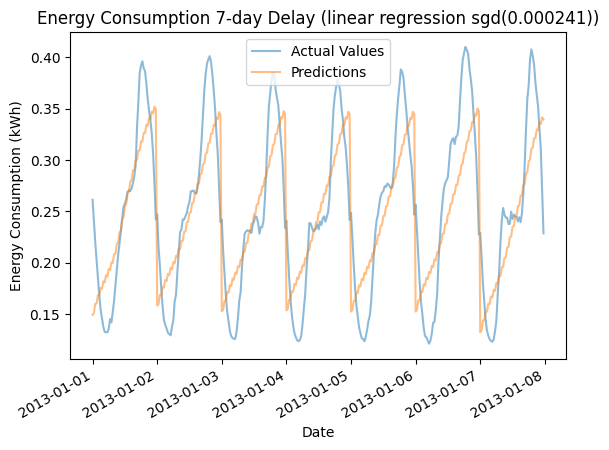

['day_of_week', 'hour_of_day', 'month'] | StandardScaler | LinearRegression
The predicted consumption is:
0.2248245185190386


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

#model = compose.Select('production', 'temp', 'holiday', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'hour_of_day', 'month', 'day_of_week')
model = compose.Select('hour_of_day', 'month', 'day_of_week')
model |= preprocessing.StandardScaler()
#check for negative values after scaling

model |= linear_model.LinearRegression(optimizer=optim.SGD(0.000241))

metric = metrics.MAE()

steps = evaluate.iter_progressive_val_score(
    dataset=stream,
    model=model,
    metric=metrics.MAE(),
    moment='DateTime',
    delay=dt.timedelta(days=7),
    step=1,
    yield_predictions=True,
)
print(model['LinearRegression'].weights)
print(model['LinearRegression'].intercept)
print(model['LinearRegression'])
start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()   
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='30min')
#remove the first timestamp
timestamps = timestamps[1:]
Mea_overtime = []

length = 0
for step in steps:
    print(step)
    length += 1
    predictions.append(step["Prediction"])
    #print(step["MAE"])
    Mea_overtime.append(str(step["MAE"]).split(" ")[1])
    #print(model['LinearRegression'].weights)
    #print(model['LinearRegression'].intercept)
    
#convert list of strings to list of floats
Mea_overtime = [float(i) for i in Mea_overtime]



# Plot the predictions
fig, ax = plt.subplots()
# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
#add title
ax.set_title('Energy Consumption over Time with a 7-day Delay (linear regression sgd(0.000241))')
# Label the y-axis
ax.set_ylabel('Energy Consumption (kWh)')
# Set the x-axis label
ax.set_xlabel('Date')

# Rotate date labels automatically
fig.autofmt_xdate()
# Add a legend
ax.legend()
plt.show()




#plotting of the predictions and actual values for a week

# Define the start and end dates
start_date = pd.to_datetime('2013-01-01')
end_date = start_date + pd.DateOffset(weeks=1)


df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter the data
week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

#combine the predictions and timestamps into a dataframe
df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

#convert datetime to datetime object
df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
fig, ax = plt.subplots()

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')

# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, alpha=0.5, label='Predictions')

# Label the y-axis
ax.set_ylabel('Energy Consumption (kWh)')
# Set the x-axis label
ax.set_xlabel('Date')
# Add a legend
ax.legend()
#add title
ax.set_title('Energy Consumption 7-day Delay (linear regression sgd(0.000241))')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()











# Plot the MAE
#fig, ax = plt.subplots()
#ax.plot_date(mdates.date2num(timestamps), Mea_overtime, linestyle='-', marker=None)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_ylim(-0.25,0.5)
#plt.show()



new_data = {'production': 1.0, 'temp': 20.0, 'holiday': 0, 'season_Autumn': 0, 'season_Spring': 1, 'season_Summer': 0, 'season_Winter': 0, 'hour_of_day': 12, 'month': 4, 'day_of_week': 2}
print(model)
# Make a prediction on the new data
prediction = model.predict_one(new_data)
print("The predicted consumption is:")
print(prediction)



In [84]:

#2018-02-04 22:45:00,10246.8760149   ,19070.7497393,0.25,0,0,0,0,1,0,0,0,1,0,0,0
#2018-02-04 23:00:00,10247.0859759    ,19070.7497393,0.2,0,0,0,0,1,0,0,0,1,0,0,0

print(model['LinearRegression'].weights)
print(model['LinearRegression'].intercept)

{"production": 0.2099, "temp": 0.2, "holiday": 0, "season_Autumn": 0, "season_Spring": 0, "season_Summer": 0, "season_Winter": 1, "hour_of_day": 4, "month": 2, "day_of_week": 2}

new_data = {"production": 0.2099, "temp": 0.2, "holiday": 0, "season_Autumn": 0, "season_Spring": 0, "season_Summer": 0, "season_Winter": 1, "hour_of_day": 4, "month": 2, "day_of_week": 2}
print(model)
# Make a prediction on the new data
prediction = model.predict_one(new_data)
print("The predicted consumption is:")
print(prediction)

{'hour_of_day': 0.059285651514782566, 'month': 0.005888768107268702, 'day_of_week': 0.007541510976830232}
0.22818984012247837
['day_of_week', 'hour_of_day', 'month'] | StandardScaler | LinearRegression
The predicted consumption is:
0.15311349449944608


In [13]:
from river import optim
from river import evaluate
from sklearn.model_selection import ParameterGrid
stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('consumption', axis=1).itertuples(index=False), df['consumption'])])
# Define the parameter grid
param_grid = {'learning_rate': [0.00026, 0.00025, 0.00024, 0.000241, 0.00032, 0.000239, 0.00028]}

# Initialize the best MAE and learning rate
best_mae = float('inf')
best_lr = None


def get_maetest(mae):
    return float(str(mae).split(" ")[1])



# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    # Create a new model with the current learning rate
    model = compose.Select('production', 'temp', 'holiday', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'hour_of_day', 'month', 'day_of_week')
    model |= preprocessing.StandardScaler()
    model |= linear_model.LinearRegression(optimizer=optim.SGD(params['learning_rate']))
    
    # Evaluate the model
    mae = evaluate.progressive_val_score(
        dataset=stream,
        model=model.clone(),
        metric=metrics.MAE(),
        moment='utc_timestamp',
        delay=dt.timedelta(days=7),
        step=1,
    )
    print(mae)
    #print(type(mae.get()))
    stream = iter(df.itertuples(index=False))
    stream = iter([(x._asdict(), y) for x, y in zip(df.drop('consumption', axis=1).itertuples(index=False), df['consumption'])])
    #print(type(best_mae))
    
    #print(float(str(mae).split(" ")[1]))
    # If the current MAE is better than the best MAE, update the best MAE and learning rate
    #print(f'Learning rate: {params["learning_rate"]}, MAE: {(mae)}')
    if mae.get() != 0 and mae.get() < best_mae:
        best_mae = mae.get()
        best_lr = params['learning_rate']

print(f'Best MAE: {best_mae}')
print(f'Best learning rate: {best_lr}')

MAE: 0.083851
MAE: 0.083835
MAE: 0.083831
MAE: 0.083831
MAE: 0.084537
MAE: 0.083831
MAE: 0.083938
Best MAE: 0.08383092548725306
Best learning rate: 0.000241


({'utc_timestamp': Timestamp('2015-10-10 16:45:00'), 'production': 0.0, 'temp': 10.45, 'holiday': 0, 'season_Autumn': 1, 'season_Spring': 0, 'season_Summer': 0, 'season_Winter': 0, 'day_of_week_Friday': 0, 'day_of_week_Monday': 0, 'day_of_week_Saturday': 1, 'day_of_week_Sunday': 0, 'day_of_week_Thursday': 0, 'day_of_week_Tuesday': 0, 'day_of_week_Wednesday': 0, 'day_of_week': 5, 'hour_of_day': 16, 'month': 10}, 0.0396815708706)
MAE: 0.0


C:\Users\stijn\AppData\Local\Temp\ipykernel_28864\940865554.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None)


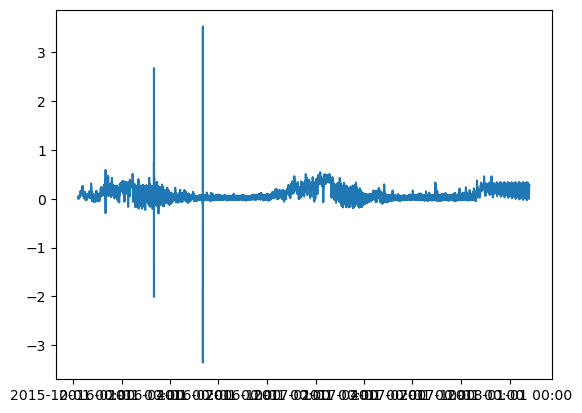

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('consumption', axis=1).itertuples(index=False), df['consumption'])])
print(next(stream))



# Initialize an empty list to store the predictions and their timestamps
predictions = []
timestamps = []

# Clone the model
model_clone = model.clone()

# Iterate over the stream
for x, y in stream:
    # Make a prediction
    y_pred = model_clone.predict_one(x)
    
    # Store the prediction and the timestamp (delayed by 24 hours)
    predictions.append(y_pred)
    timestamps.append(x['utc_timestamp'] + dt.timedelta(hours=24))
    
    # Update the model
    model_clone.learn_one(x, y)

#print the metrics
print(f'MAE: {metric.get()}')

# Plot the predictions
fig, ax = plt.subplots()
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None)

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()